# Evaluasi Pipeline Integrasi (3 Model + Radiomics)

Notebook ini mengevaluasi performa pipeline `main.py` pada seluruh dataset yang ada di folder `Dataset`.

**Langkah-langkah:**
1. Load Dataset (Image Paths & Labels).
2. Load Models (ResNet50, DenseNet201, DenseNet121, ML Pipeline).
3. Ekstraksi Fitur dari setiap gambar (Deep Features + Radiomics Frequency).
4. Fusion & Prediksi.
5. Hitung Metrik & Generate Confusion Matrix.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import joblib
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from utils import (
    GradCAM, 
    extract_frequency_features, 
    preprocess_resnet,
    preprocess_densenet201_keras,
    preprocess_densenet121_pytorch,
    load_pytorch_densenet121,
    load_keras_model_feature_extractor
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2025-12-27 13:33:46.225768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-27 13:33:46.326169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-27 13:33:48.597153: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# ============================
# 1. KONFIGURASI & LOAD DATA
# ============================

DATASET_DIR = "Dataset"
CLASSES = ['benign', 'malignant', 'normal'] # Folder names
CLASS_MAP = {name: idx for idx, name in enumerate(CLASSES)}
print(f"Class Mapping: {CLASS_MAP}")

image_paths = []
y_true = []

print("Loading dataset paths...")
for cls in CLASSES:
    folder_path = os.path.join(DATASET_DIR, cls)
    files = glob.glob(os.path.join(folder_path, "*.*(")) # Catch likely images
    # Better wildcard strategy
    types = ('*.png', '*.jpg', '*.jpeg', '*.bmp')
    files = []
    for t in types:
        files.extend(glob.glob(os.path.join(folder_path, t)))
        # Handle mixed case extensions if needed (linux is case sensitive)
        files.extend(glob.glob(os.path.join(folder_path, t.upper())))
        
    print(f"   {cls}: {len(files)} images")
    for f in files:
        image_paths.append(f)
        y_true.append(CLASS_MAP[cls])

print(f"Total Images: {len(image_paths)}")

Class Mapping: {'benign': 0, 'malignant': 1, 'normal': 2}
Loading dataset paths...
   benign: 537 images
   malignant: 360 images
   normal: 133 images
Total Images: 1030


In [3]:
# ============================
# 2. LOAD MODELS (SEKALI SAJA)
# ============================

PATH_MODEL_DN121 = 'model DL/model_densenet121_humic.pth'
PATH_MODEL_DN201 = 'model DL/DenseNet201_2.keras'
PATH_MODEL_RESNET = 'model DL/best_resnet50_medianfilter_fixed.keras'
PATH_ML_PIPELINE = 'model_lgbm_machinelearning.joblib'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading DenseNet121 (PyTorch)...")
model_dn121 = load_pytorch_densenet121(PATH_MODEL_DN121, device)

print("Loading DenseNet201 (Keras)...")
model_dn201 = load_keras_model_feature_extractor(PATH_MODEL_DN201)

print("Loading ResNet50 (Keras)...")
model_resnet = load_keras_model_feature_extractor(PATH_MODEL_RESNET)

print("Loading ML Pipeline...")
ml_pipeline = joblib.load(PATH_ML_PIPELINE)

Using device: cuda
Loading DenseNet121 (PyTorch)...
Loading DenseNet201 (Keras)...


I0000 00:00:1766817229.768529   14448 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Loaded Keras model from DenseNet201_2.keras. Extracting from layer: dense
Loading ResNet50 (Keras)...
Loaded Keras model from best_resnet50_medianfilter_fixed.keras. Extracting from layer: dense_1
Loading ML Pipeline...


In [4]:
# ============================
# 3. INFERENCE LOOP
# ============================

y_pred = []
probs = []
failed_indices = []

print("Starting Inference...")

for idx, img_path in enumerate(tqdm(image_paths)):
    try:
        # --- 1. DenseNet121 & GradCAM ---
        tensor_dn121, img_processed_dn121 = preprocess_densenet121_pytorch(img_path, device)
        
        with torch.no_grad():
            features_map = model_dn121.features(tensor_dn121)
            feat_dn121 = torch.nn.functional.adaptive_avg_pool2d(features_map, (1, 1))
            feat_dn121 = torch.flatten(feat_dn121, 1).cpu().numpy().flatten()
            
        # GradCAM for Frequency Features
        target_layer = model_dn121.features.denseblock4.denselayer16.conv2
        gradcam = GradCAM(model_dn121, target_layer)
        heatmap, _ = gradcam(tensor_dn121)
        
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        _, mask = cv2.threshold(np.uint8(255 * heatmap_resized), 127, 255, cv2.THRESH_BINARY)
        
        # Frequency Features
        img_bgr = cv2.imread(img_path)
        img_resized = cv2.resize(img_bgr, (224, 224))
        gray_image = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        
        freq_feats_dict = extract_frequency_features(gray_image, mask)
        freq_feats = []
        for key in sorted(freq_feats_dict.keys()):
             freq_feats.append(freq_feats_dict[key])
        freq_feats = np.array(freq_feats)

        # --- 2. DenseNet201 ---
        x_dn201 = preprocess_densenet201_keras(img_path)
        feat_dn201 = model_dn201.predict(x_dn201, verbose=0).flatten()

        # --- 3. ResNet50 ---
        x_resnet = preprocess_resnet(img_path)
        feat_resnet = model_resnet.predict(x_resnet, verbose=0).flatten()

        # --- 4. Fusion ---
        fused_features = np.concatenate([freq_feats, feat_dn121, feat_dn201, feat_resnet])
        
        # FIX: Mismatch 1420 vs 1419
        EXPECTED_DIM = 1419
        if fused_features.shape[0] > EXPECTED_DIM:
            fused_features = fused_features[:EXPECTED_DIM]
        elif fused_features.shape[0] < EXPECTED_DIM:
            padding = np.zeros(EXPECTED_DIM - fused_features.shape[0])
            fused_features = np.concatenate([fused_features, padding])
            
        X_input = fused_features.reshape(1, -1)

        # --- 5. Prediction (with NaN handling) ---
        if isinstance(ml_pipeline, dict):
            scaler = ml_pipeline.get('scaler')
            reducer = ml_pipeline.get('reducer')
            clf = ml_pipeline.get('classifier') or ml_pipeline.get('model')
            
            if np.isnan(X_input).any():
                nan_indices = np.where(np.isnan(X_input))
                if hasattr(scaler, 'mean_'):
                     X_input[nan_indices] = scaler.mean_[nan_indices[1]]
                else:
                     X_input = np.nan_to_num(X_input, nan=0.0)

            if scaler: X_input = scaler.transform(X_input)
            if reducer: X_input = reducer.transform(X_input)
            
            pred = clf.predict(X_input)[0]
        else:
            X_input = np.nan_to_num(X_input, nan=0.0)
            pred = ml_pipeline.predict(X_input)[0]
            
        y_pred.append(int(pred))
        
    except Exception as e:
        print(f"\nError processing {img_path}: {e}")
        y_pred.append(-1) # Mark as failed
        failed_indices.append(idx)

Starting Inference...


  0%|          | 0/1030 [00:00<?, ?it/s]2025-12-27 13:34:08.494073: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d2d3c0d38a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-27 13:34:08.494108: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-27 13:34:08.863648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-27 13:34:12.676764: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1766817276.637100   14620 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 1030/1030 [09:17<00:00,  1.85it/s]



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      benign       0.78      0.85      0.81       537
   malignant       0.12      0.01      0.02       360
      normal       0.28      0.87      0.42       133

    accuracy                           0.56      1030
   macro avg       0.39      0.58      0.42      1030
weighted avg       0.48      0.56      0.48      1030

Accuracy: 0.5592233009708738


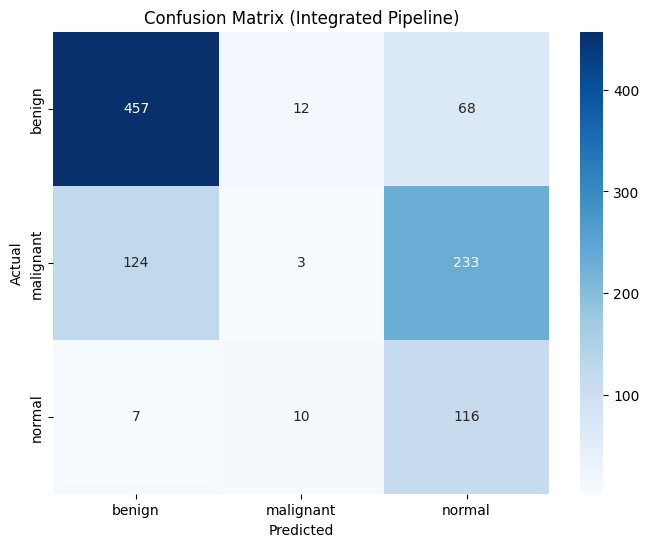

In [5]:
# ============================
# 4. EVALUATION & VISUALIZATION
# ============================

# Filter out failures if any
y_true_clean = [t for i, t in enumerate(y_true) if i not in failed_indices]
y_pred_clean = [p for i, p in enumerate(y_pred) if i not in failed_indices]

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true_clean, y_pred_clean, target_names=CLASSES))

print("Accuracy:", accuracy_score(y_true_clean, y_pred_clean))

# Confusion Matrix
cm = confusion_matrix(y_true_clean, y_pred_clean)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Integrated Pipeline)')
plt.show()